# Method of Regularized Stokeslet
## Introduction
**This work was done as a part of the final project for a special topics course titled _Boundary integral method_ in the fall of 22 by [Professor Cortez](https://en.wikipedia.org/wiki/Ricardo_Cortez_(mathematician))**

The fluid flow problems in tiny scales is usually modeled  by the Stokes equations for incompressible flows 
  $$\mu \Delta \textbf{u}=\nabla p-\textbf{F}$$
  $$ \nabla \cdot \textbf{u}=0$$
where $\mu$ is the fluid viscosity, $p$ is the pressure, $\textbf{u}$ is the velocity, and $\textbf{F}$ is force. A fundamental solution of these equations is called a $Stokeslet$. The particular case of a single force $\mathbf{f}_0$ exerted at $\mathbf{x}_0$ results in a velocity  field given by
$$\mathbf{u}=\frac{\mathbf{f}_0}{8\pi\mu r}+\frac{(\mathbf{f_0\cdot(x-x_0)})(\mathbf{x-x_0})}{8
\pi\mu r}$$
where $r=||\mathbf{x-x_0}||$.

Note this solution is undefined at $r=0$ or $\mathbf{x=x}_0$.

However, the singularities can be eliminated through the function(usually known as blob fuction) $\phi_{\delta}(\mathbf{x})$ which is a radially symmetric and satisfy that the integral over the space is one. So, considering $\mathbf{F}=\mathbf{f}_0\phi_{\delta}$ the singularity can be removed. The idea is due to [Professor Cortez](https://epubs.siam.org/doi/10.1137/S106482750038146X).

With the following choice of blob function:
$$\phi_\delta(r)=\dfrac{15\delta^4}{8\pi(r^2+\delta^2)^{\frac{7}{2}}}$$
the regularized stokeslet is 
$$\vec{u}(x)=\boldsymbol f_0 \dfrac{r^2+2\delta^2}{8\pi\mu(r^2+\delta^2)^{\frac{3}{2}}}+\dfrac{(\boldsymbol f_{0} .\boldsymbol x)\boldsymbol x}{8\pi\mu(r^2+\delta^2)^{\frac{3}{2}}}$$



## Swimming of filament immersed in a viscous fluid

We suppose the slender body is a sine wave,
$$y(s)=A\cos(\lambda s-2\pi t),z(s)=0$$
and $x(s)$ such that $\sqrt{(x')^2+(y')^2}=1$,
and the curvature 
\begin{align*}
    \kappa=&\frac{x''y'-y'x''}{(\sqrt{(x')^2+(y')^2})^{3}}\\=&x''y'-y'x''\\=&\frac{-y''}{\sqrt{1-(y')^2}}
\end{align*}
To compute the forces and energy we've utilized Lighthill's slender body theory.

Once we've computed forces at each point, we can calculate velocity. Then, the locomotion of filament can be found by solving $\dfrac{d\boldsymbol X}{dt}=\boldsymbol u$ . To solve this we have used the forward Euler method(other methods like RK can also be used).

In [1]:
function velocityRS(x,y,s,F,delta, δs)
    
    u = zeros(2, length(s))
    int_u = zeros(size(u))
    for i = 1:length(s)

        r1 = x .- x[i]
        r2 = y .- y[i]
        R2 = r1 .^ 2 .+ r2 .^ 2
        F_dot_r = (F[1, i] .* r1) .+ (F[2, i] .* r2)

        int_u[1, :] = (1 / (8 * pi)) * ((F[1, i] .* (R2 .+ 2 * delta^2)) ./ ((R2 .+ delta^2) .^ 1.5) .+ (F_dot_r .* (r1)) ./ ((R2 .+ delta^2) .^ 1.5))

        int_u[2, :] = (1 / (8 * pi)) * ((F[2, i] .* (R2 .+ 2 * delta^2)) ./ ((R2 .+ delta^2) .^ 1.5) .+ (F_dot_r .* (r2)) ./ ((R2 .+ delta^2) .^ 1.5))

        if i != 1 && i != length(s)
            u[1, :] = u[1, :] .+ (int_u[1, :]) * δs
            u[2, :] = u[2, :] .+ (int_u[2, :]) * δs
        else
            u[1, :] = u[1, :] .+ 0.5 * (int_u[1, :]) * δs
            u[2, :] = u[2, :] .+ 0.5 * (int_u[2, :]) * δs
        end
    end
    return u
end

velocityRS (generic function with 1 method)

[ Info: Saved animation to C:\Users\mosle\OneDrive - Tulane University\anim_RS0001.gif


Plots.AnimatedGif("C:\\Users\\mosle\\OneDrive - Tulane University\\anim_RS0001.gif")
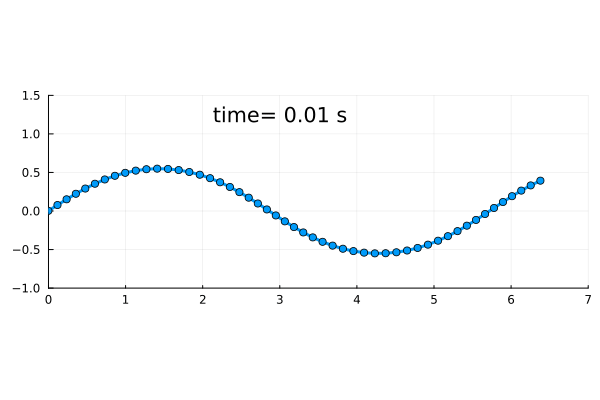

In [2]:
# import Pkg; Pkg.add("DifferentialEquations")
# import Pkg; Pkg.add("Plots")
using DifferentialEquations, Plots

S_T = 64;
S_C = 12;
L = 7;
Amp = 0.55;
λ = 2.25 * π / L;


N = 51;
δs = L / (N - 1);
s_range = (0.0, 7.0);

δ = (2 / 3) * δs;
f(u, p, s) = sqrt(1 - Amp .^ 2 * λ .^ 2 * (cos(λ * s)) .^ 2)

x0 = 0;
prob = ODEProblem(f, x0, s_range)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, saveat=δs)

y = Amp * sin.(λ * sol.t);


delta = (2 / 3) * δs;

s = sol.t
x = sol';
y = y';

k(ss, tt) = Amp * λ^2 * sin(λ * ss - 2 * pi * tt) / (sqrt(1 - Amp^2 * λ^2 * (cos(λ * ss - 2 * pi * tt))^2));

F = zeros(2, length(s));
t = 0;

dt = 1e-4;
tmax = 1;
nmax = round(tmax / dt);
anim=Animation()
for n = 1:nmax

    for i = 1:length(s)-1
        X_s = [x[i+1] .- x[i], y[i+1] .- y[i]]
        X_s_distance2 = (X_s[1] .^ 2 .+ X_s[2] .^ 2)
        F_t = -S_T * ((sqrt(X_s_distance2) / δs) - 1) .* (X_s ./ (sqrt(X_s_distance2)))

        F[1, i] = F[1, i] .- F_t[1]
        F[1, i+1] = F[1, i+1] .+ F_t[1]
        F[2, i] = F[2, i] .- F_t[2]
        F[2, i+1] = F[2, i+1] .+ F_t[2]
    end

    for i = 2:length(s)-1
        κ = k.(s[i], t)

        D2_x_i = (x[i+1] .- 2 * x[i] .+ x[i-1]) / (δs^2)
        D0_x_i = (x[i+1] .- x[i-1]) / (2 * δs)

        D2_y_i = (y[i+1] .- 2 * y[i] .+ y[i-1]) / (δs^2)
        D0_y_i = (y[i+1] .- y[i-1]) / (2 * δs)


        F1 = S_C * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D0_y_i / δs)
        F2 = -S_C * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D0_x_i / δs)
        Q1 = -S_C * 0.5 * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D2_y_i)
        Q2 = S_C * 0.5 * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D2_x_i)

        F[1, i+1] = F[1, i+1] .- F1 .- Q1
        F[1, i] = F[1, i] .+ 2 * F1
        F[1, i-1] = F[1, i-1] .- F1 .+ Q1

        F[2, i+1] = F[2, i+1] .- F2 .- Q2
        F[2, i] = F[2, i] .+ 2 * F2
        F[2, i-1] = F[2, i-1] .- F2 .+ Q2
    end

    u=velocityRS(x,y,s,F,delta,δs);
# Euler method to update location
    for i = 1:length(s)

        x[i] = x[i] .+ dt * u[1, i]
        y[i] = y[i] .+ dt * u[2, i]

    end

    t = t + dt

    if mod(n, 100) == 0

        plot(x', y', xlims=(0,L),ylims=(-1,1.5),aspect_ratio=:equal, legend=:false,marker=:circle,lw=3)
#     quiver!(x',y',quiver=(F[1,:]',F[2,:]'))

        annotate!(3, 1.25, "time= $(rpad(round(t; digits=2),4,"0")) s")
        frame(anim)


        #sleep(dt)

    end

end

gif(anim, "anim_RS0001.gif", fps = 10)

